<a href="https://colab.research.google.com/github/seojeongyun/FATHER_ROS/blob/main/%5B1%5D_Autograd_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=f5f6d920f9702e5f84d8445220f505ff9dda0adbbc0d129b71caf033b40de1f8
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


## Libraries

In [ ]:
import torchviz

In [ ]:
import torch

import torch.nn as nn
import torch.nn.functional as F

import numpy as np

## 1. Autograd Study
* https://pytorch.org/tutorials/intermediate/custom_function_double_backward_tutorial.html

### 1-1) Example 1: Square Function

In [ ]:

class Square(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        # Because we are saving one of the inputs use `save_for_backward`
        # Save non-tensors and non-inputs/non-outputs directly on ctx
        ctx.save_for_backward(x)
        return x**2

    @staticmethod
    def backward(ctx, grad_out):
        # A function support double backward automatically if autograd
        # is able to record the computations performed in backward
        x, = ctx.saved_tensors
        return grad_out * 2 * x

In [ ]:
# Use double precision because finite differencing method magnifies errors
x = torch.rand(3, 3, requires_grad=True, dtype=torch.double)
torch.autograd.gradcheck(Square.apply, x)

True

In [ ]:
x = torch.tensor(1., requires_grad=True)
print(x)

tensor(1., requires_grad=True)


In [ ]:
out = Square.apply(x)
print(out)

tensor(1., grad_fn=<SquareBackward>)


In [ ]:
grad_x, = torch.autograd.grad(outputs=out, inputs=x, create_graph=True)

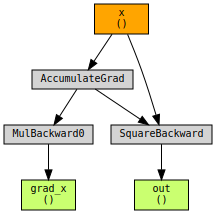

In [ ]:
torchviz.make_dot((grad_x, x, out), {"grad_x": grad_x, "x": x, "out": out})

### 1-2) Example 2: LegendrePolynomial3

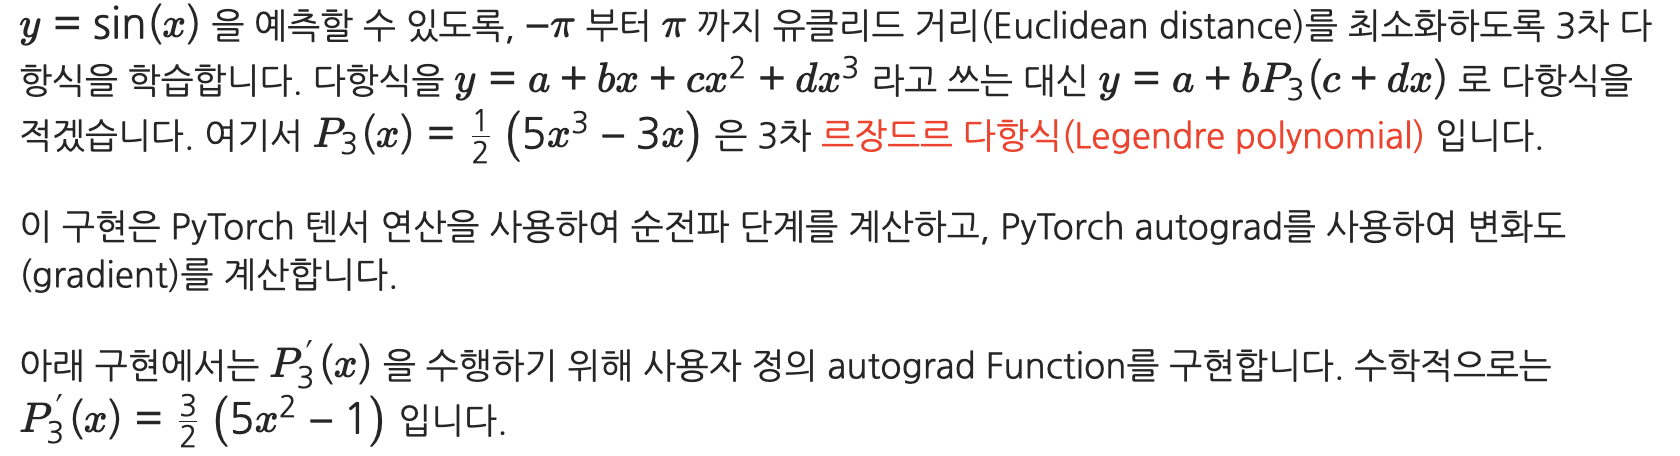

In [ ]:
import math

In [ ]:
class LegendrePolynomial3(torch.autograd.Function):
    """
    torch.autograd.Function을 상속받아 사용자 정의 autograd Function을 구현하고,
    텐서 연산을 하는 순전파 단계와 역전파 단계를 구현해보겠습니다.
    """

    @staticmethod
    def forward(ctx, input):
        """
        순전파 단계에서는 입력을 갖는 텐서를 받아 출력을 갖는 텐서를 반환합니다.
        ctx는 컨텍스트 객체(context object)로 역전파 연산을 위한 정보 저장에 사용합니다.
        ctx.save_for_backward 메소드를 사용하여 역전파 단계에서 사용할 어떤 객체도
        저장(cache)해 둘 수 있습니다.
        """
        ctx.save_for_backward(input)
        return 0.5 * (5 * input ** 3 - 3 * input)

    @staticmethod
    def backward(ctx, grad_output):
        """
        역전파 단계에서는 출력에 대한 손실(loss)의 변화도(gradient)를 갖는 텐서를 받고,
        입력에 대한 손실의 변화도를 계산해야 합니다.
        """
        input, = ctx.saved_tensors
        return grad_output * 1.5 * (5 * input ** 2 - 1)

In [ ]:
x = torch.tensor(1., requires_grad=True)

In [ ]:
out = LegendrePolynomial3.apply(x)

In [ ]:
grad_x, = torch.autograd.grad(outputs=out, inputs=x, create_graph=True)

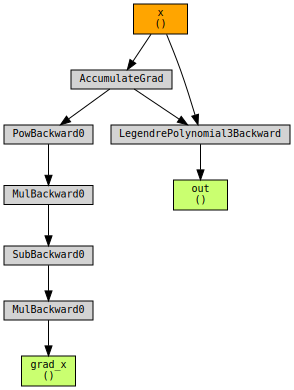

In [ ]:
torchviz.make_dot((grad_x, x, out), {"grad_x": grad_x, "x": x, "out": out})

## 2. Autograd and Module
* https://stackoverflow.com/questions/69500995/is-there-a-way-to-overide-the-backward-operation-on-nn-module

### Autograd

In [ ]:
class Func_(torch.autograd.Function):
    """Both forward and backward are static methods."""

    @staticmethod
    def forward(ctx, input, weights):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input, weights)
        return input * weights

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the inputs: here input and weights
        """
        input, weights = ctx.saved_tensors

        grad_input = weights.clone() * grad_output
        grad_weights = input.clone() * grad_output

        return grad_input, grad_weights

In [ ]:
class LayerWithCustomGrad(nn.Module):
    def __init__(self, num_weights=10):
        super().__init__()

        self.weights = nn.Parameter(torch.rand(num_weights))
        self.fn = Func_.apply

    def forward(self, x):
        return self.fn(x, self.weights)

In [ ]:
num_weights = 1

layer = LayerWithCustomGrad(num_weights = num_weights)

In [ ]:
x = torch.randn(3, requires_grad=True)
out = layer(x)

print(x)
print(out)

tensor([-0.5552, -0.3473, -1.7213], requires_grad=True)
tensor([-0.2662, -0.1666, -0.8254], grad_fn=<Func_Backward>)


In [ ]:
out.mean().backward(retain_graph=True)

In [ ]:
print(x.grad)

tensor([0.1598, 0.1598, 0.1598])


In [ ]:
print(layer.weights.grad)

tensor([-0.8746])


In [ ]:
grad_x, = torch.autograd.grad(outputs=out, inputs=x, grad_outputs=torch.ones(num_weights), create_graph=True)

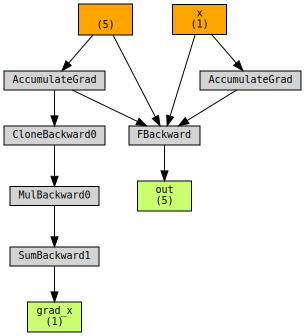

In [ ]:
torchviz.make_dot((grad_x, x, out), {"grad_x": grad_x, "x": x, "out": out})

## 3. ReLU alpha

In [ ]:
class _fn_ReLU_alpha(torch.autograd.Function):
    """Both forward and backward are static methods."""

    @staticmethod
    def forward(ctx, input, weights):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input, weights)
        #
        input_ = input.clone()
        input_[input_ < 0.] = 0.
        input_[input_ > weights] = weights
        #
        return input_

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the inputs: here input and weights
        """
        input, weights = ctx.saved_tensors
        #
        grad_input = input.clone()
        grad_input[input < 0.] = 0.
        grad_input[input > weights] = 0.
        grad_input[grad_input != 0.] = 1.
        grad_input = grad_input * grad_output
        #
        grad_weights = input.clone()
        grad_weights[input < weights] = 0.
        grad_weights[input >= weights] = 1.
        grad_weights = grad_weights * grad_output
        #
        return grad_input, grad_weights

In [ ]:
class ReLU_alpha(nn.Module):
    def __init__(self, device, init_value = 4.):
        super().__init__()
        self.weights = nn.Parameter(torch.tensor(init_value).unsqueeze(dim=0))
        self.fn = _fn_ReLU_alpha.apply

        self.device = device

    def forward(self, x):
        weights = F.linear(
            torch.tensor(1., requires_grad=True, device=self.device).unsqueeze(dim=0),
            self.weights
            )
        x = self.fn(x, 2**weights)

        return x

In [ ]:
# Use double precision because finite differencing method magnifies errors
x = torch.rand(3, requires_grad=True, dtype=torch.double).unsqueeze(dim=0)
w = torch.rand(1, requires_grad=True, dtype=torch.double).unsqueeze(dim=0)
torch.autograd.gradcheck(_fn_ReLU_alpha.apply, (x, w))

True

In [ ]:
layer_relu_alpha = ReLU_alpha(device=torch.device('cpu'))

In [ ]:
x = torch.rand(3, requires_grad=True)
out = layer_relu_alpha(x)

print("x      : ", x.data)
print("weights: ", layer_relu_alpha.weights.data)
print("out    : ", out.data)

x      :  tensor([0.7775, 0.9003, 0.7256])
weights:  tensor([4.])
out    :  tensor([0.7775, 0.9003, 0.7256])


In [ ]:
out.mean().backward(retain_graph=True)

In [ ]:
print(x.grad)

tensor([0.3333, 0.3333, 0.3333])


In [ ]:
print(layer_relu_alpha.weights.grad)

tensor([0.])


In [ ]:
grad_x, = torch.autograd.grad(outputs=out, inputs=x, grad_outputs=torch.ones(len(x)), create_graph=True)

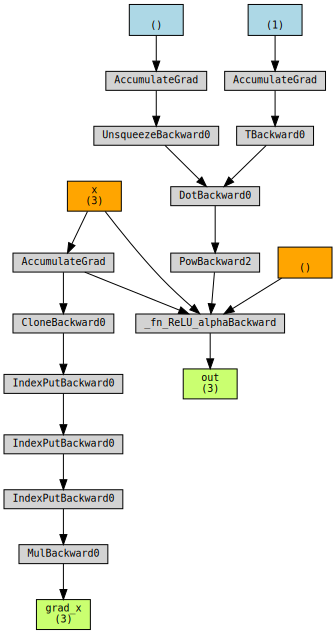

In [ ]:
torchviz.make_dot((grad_x, x, out), {"grad_x": grad_x, "x": x, "out": out})

## 4. Bit-like ReLU alpha generating unsigned values

In [ ]:
class _fn_ReLU_alpha(torch.autograd.Function):
    """Both forward and backward are static methods."""

    @staticmethod
    def forward(ctx, input, weights):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input, weights)
        #
        input_ = input.clone()
        input_[input_ < 0.] = 0.
        input_[input_ > 2**weights - 1] = 2**weights - 1
        #
        return input_

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the inputs: here input and weights
        """
        input, weights = ctx.saved_tensors
        #
        grad_input = input.clone()
        grad_input[input < 0.] = 0.
        grad_input[input > 2**weights - 1] = 0.
        grad_input[grad_input != 0.] = 1.
        grad_input = grad_input * grad_output
        #
        grad_weights = input.clone()
        grad_weights[input < 2**weights - 1] = 0.
        grad_weights[input >= 2**weights - 1] = (2**weights) * torch.log(torch.tensor(2))
        grad_weights = grad_weights * grad_output
        #
        return grad_input, grad_weights

In [ ]:
# Use double precision because finite differencing method magnifies errors
# 이것은 구현된 backward 를 jacobian 방식으로 numerically (실험적으로) test를 하였을 때,
# 제대로 구현되어 있는지를 알려주는 torch 내부의 함수
total = 1000

x = []
w = []
for _ in range(total):
    x.append(torch.randint(5, 200, (1, 3), requires_grad=True, dtype=torch.double))
    w.append(torch.randint(5, 200, (1, 1), requires_grad=True, dtype=torch.double))

In [ ]:
correct = 0

for n_iters in range(total):
    try:
        if torch.autograd.gradcheck(_fn_ReLU_alpha.apply, (x[n_iters], w[n_iters])):
            correct += 1
    except:
        continue

print("correct: ", correct)
print("n_iters: ", n_iters + 1)

correct:  1000
n_iters:  1000


In [ ]:
torch.autograd.gradcheck(_fn_ReLU_alpha.apply, (x[0], w[0]))

True

In [ ]:
class ReLU_alpha(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.tensor(2.).unsqueeze(dim=0))
        self.fn = _fn_ReLU_alpha.apply

    def forward(self, x):
        weights = F.linear(torch.tensor(1., requires_grad=True).unsqueeze(dim=0), self.weights)
        x = self.fn(x, weights)

        return x

In [ ]:
layer = ReLU_alpha()

In [ ]:
x = torch.randint(1,10,(1,3), requires_grad=True, dtype=torch.double)
out = layer(x)

print("x      : ", x.data)
print("weights: ", layer.weights.data)
print("out    : ", out.data)

x      :  tensor([[9., 2., 7.]], dtype=torch.float64)
weights:  tensor([2.])
out    :  tensor([[3., 2., 3.]], dtype=torch.float64)


In [ ]:
out.mean().backward(retain_graph=True)

In [ ]:
print(x.grad)

tensor([[0.0000, 0.3333, 0.0000]], dtype=torch.float64)


In [ ]:
print(layer.weights.grad)

tensor([1.8484])


In [ ]:
grad_x, = torch.autograd.grad(outputs=out, inputs=x, grad_outputs=torch.ones(1,3), create_graph=True)

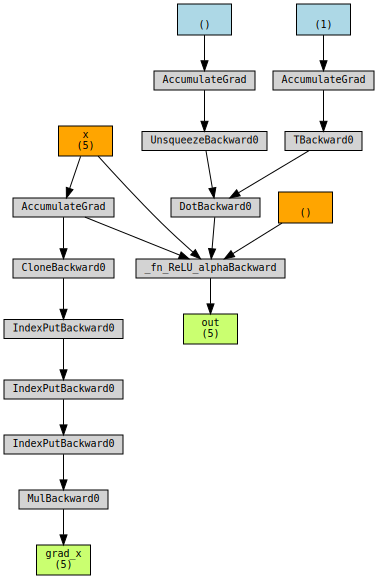

In [ ]:
torchviz.make_dot((grad_x, x, out), {"grad_x": grad_x, "x": x, "out": out})

## 5. Bit-like ReLU alpha generating signed values

In [ ]:
class _fn_ReLU_alpha_with_negative_limitations(torch.autograd.Function):
    """Both forward and backward are static methods."""

    @staticmethod
    def forward(ctx, input, weights):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input, weights)
        #
        input_ = input.clone()
        input_[input_ < (-1 * 2**(weights-1))] = -1 * 2**(weights-1)
        input_[input_ > (2**(weights-1) - 1)] = 2**(weights-1) - 1
        #
        return input_

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the inputs: here input and weights
        """
        input, weights = ctx.saved_tensors
        #
        grad_input = input.clone()
        grad_input[input < (-1 * 2**(weights-1))] = 0.
        grad_input[input > (2**(weights-1) - 1)] = 0.
        grad_input[grad_input != 0.] = 1.
        grad_input = grad_input * grad_output
        #
        grad_weights = input.clone()
        grad_weights[input < (2**(weights-1) - 1)] = 0.
        grad_weights[input > (2**(weights-1) - 1)] = (2**(weights-1) * torch.log(torch.tensor(2)))
        grad_weights[input < (-1 * 2**(weights-1))] = -1 * (2**(weights-1) * torch.log(torch.tensor(2)))
        grad_weights = grad_weights * grad_output
        #
        return grad_input, grad_weights

SyntaxError: invalid syntax (<ipython-input-41-1c9b69f657bf>, line 14)

In [ ]:
# Use double precision because finite differencing method magnifies errors
# 이것은 구현된 backward 를 jacobian 방식으로 numerically (실험적으로) test를 하였을 때,
# 제대로 구현되어 있는지를 알려주는 torch 내부의 함수
total = 1000

x = []
w = []
for _ in range(total):
    x.append(torch.rand(1, 3, requires_grad=True, dtype=torch.double))
    w.append(torch.rand(1, requires_grad=True, dtype=torch.double))

In [ ]:
correct = 0

for n_iters in range(total):
    try:
        if torch.autograd.gradcheck(_fn_ReLU_alpha_with_negative_limitations.apply, (x[n_iters], w[n_iters])):
            correct += 1
    except:
        continue

print("correct: ", correct)
print("n_iters: ", n_iters + 1)

correct:  1000
n_iters:  1000


In [ ]:
class ReLU_alpha(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.tensor(128.).unsqueeze(dim=0))
        self.fn = _fn_ReLU_alpha_with_negative_limitations.apply

    def forward(self, x):
        weights = F.linear(torch.tensor(1., requires_grad=True).unsqueeze(dim=0), self.weights)
        x = self.fn(x, weights)

        return x

In [ ]:
layer = ReLU_alpha()

In [ ]:
x = torch.rand(5, requires_grad=True)
out = layer(x)

print("x      : ", x.data)
print("weights: ", layer.weights.data)
print("out    : ", out.data)

x      :  tensor([0.6408, 0.3755, 0.3575, 0.2761, 0.2953])
weights:  tensor([128.])
out    :  tensor([0.6408, 0.3755, 0.3575, 0.2761, 0.2953])


In [ ]:
out.mean().backward(retain_graph=True)

In [ ]:
print(x.grad)

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])


In [ ]:
print(layer.weights.grad)

tensor([0.])


In [ ]:
grad_x, = torch.autograd.grad(outputs=out, inputs=x, grad_outputs=torch.ones(5), create_graph=True)

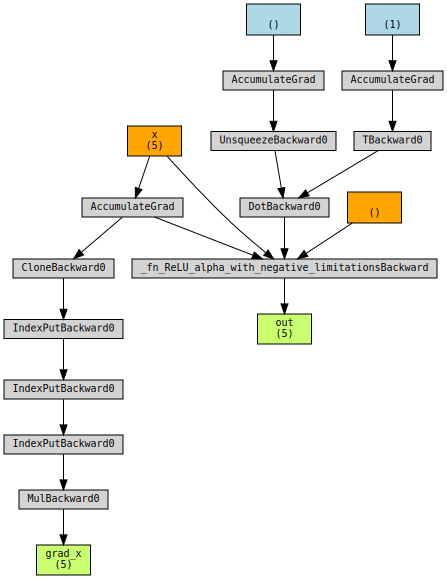

In [ ]:
torchviz.make_dot((grad_x, x, out), {"grad_x": grad_x, "x": x, "out": out})